# Differential expression and gene ontolgies of cancer integrated SEACells: Metastasis

In [1]:
import os
import logging
import shutil

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams

In [4]:
from gprofiler import GProfiler

In [5]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.2
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
brotli              1.0.9
certifi             2023.07.22
cffi                1.15.0
charset_normalizer  3.2.0
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
exceptiongroup      1.1.3
executing           1.2.0
fastjsonschema      NA
gprofiler           1.0.0
h5py                3.9.0
idna                3.4
igraph              0.10.6
importlib_resources NA
ipykernel           6.25.0
ipywidgets          8.1.0
jedi                0.19.0
jinja2              3.1.2
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_events      0.6.3
jupyter_server      2.7.3
jupyterlab_server   2.24.0
kiwisolver          1.4.5
leidenalg           0

In [6]:
pwd

'/home/marta.sallese/ov_cancer_atlas/atlas_project/script/downstream/clustering/cancer'

In [7]:
from plotting_bubble import scale_data_5_75, plot_enrich 
# from plotting_bubble import plot_enrich

In [6]:
def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=True, filename = './bubbleplot.png', show = False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    data_to_plot['name_display'] = data_to_plot['source'] + '_' + data_to_plot['name']
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")


    path = plt.scatter(x='recall', y="name_display", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(filename, dpi=300, format='png', bbox_inches='tight')
        plt.close()
    if show:
        plt.show()

In [8]:
adata = sc.read('/group/testa/Project/OvarianAtlas/Integrated_data_hdg_new/seacells_cancer_hdg_patients_batch_corr_scgen_tissuetreat.h5ad')
# import configparser

# # Read configuration file
# config = configparser.ConfigParser()
# config.read("../../utils/config.ini")

# rawPath = config.get("DEFAULT", "rawPath")

# adata = sc.read(rawPath + 'integration/metacells/seacells_cancer_hdg_patients_batch_corr_scgen_tissuetreat.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 8735 × 17054
    obs: 'tissue', 'developmental_stage', 'treatment', 'recurrence', 'tumor_stage', 'paper_ID', 'anatomical_location', 'dataset', 'SEACell', '# Single Cells', 'tissue-treatment', '_scvi_batch', '_scvi_labels', 'concat_batch'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'corrected_latent', 'latent'

In [10]:
adata.obs = adata.obs.drop(columns=['_scvi_batch', '_scvi_labels', 'concat_batch'])

In [11]:
hvg = pd.read_csv('/home/marta.sallese/ov_cancer_atlas/Atlas_scripts/HVG/atlas_cancer_hdg_dispersion_patients.csv',  index_col=0)
# hvg = pd.read_csv('/home/marta.sallese/ov_cancer_atlas/atlas_project/script/hdg/cancer/atlas_cancer_hdg_dispersion_patients.csv',  index_col=0)

In [12]:
hvg[hvg.highly_variable]

highly_variable
FAM87B              True
SAMD11              True
PLEKHN1             True
HES4                True
ISG15               True
...                  ...
MT-ND3              True
MT-ND4L             True
MT-ND5              True
MT-ND6              True
MT-CYB              True

[5028 rows x 1 columns]

In [13]:
hvg.highly_variable.sum()

5028

In [14]:
adata.var

Empty DataFrame
Columns: []
Index: [FAM87B, LINC00115, FAM41C, SAMD11, NOC2L, KLHL17, PLEKHN1, HES4, ISG15, AGRN, RNF223, C1orf159, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, UBE2J2, SCNN1D, ACAP3, PUSL1, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20, ANKRD65, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, NADK, GNB1, CALML6, TMEM52, GABRD, PRKCZ, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, HES5, TNFRSF14, MMEL1, TTC34, PRDM16, ARHGEF16, MEGF6, TPRG1L, WRAP73, TP73, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, LINC01134, AJAP1, NPHP4, KCNAB2, CHD5, RPL22, RNF207, ICMT, LINC00337, GPR153, ACOT7, HES2, ESPN, TNFRSF25, PLEKHG5, NOL9, TAS1R1, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, PER3, UTS2, TNFRSF9, PARK7, ERRFI1, SLC45A1, RERE, ENO1, CA6, ...]

[17054 rows x 0 columns]

In [15]:
adata.var['highly_variable']=hvg.highly_variable

In [16]:
adata.var

highly_variable
FAM87B               True
LINC00115             NaN
FAM41C                NaN
SAMD11               True
NOC2L                 NaN
...                   ...
MT-ND4L              True
MT-ND4                NaN
MT-ND5               True
MT-ND6               True
MT-CYB               True

[17054 rows x 1 columns]

In [17]:
adata.var.highly_variable = adata.var.highly_variable.fillna(False)

In [18]:
adata.var

highly_variable
FAM87B                True
LINC00115            False
FAM41C               False
SAMD11                True
NOC2L                False
...                    ...
MT-ND4L               True
MT-ND4               False
MT-ND5                True
MT-ND6                True
MT-CYB                True

[17054 rows x 1 columns]

In [19]:
# you can skip this passage if you specify use_highly_variable = True when computing embeddings
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

In [19]:
adata.var_names

Index(['FAM87B', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'HES4', 'ISG15', 'AGRN',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=17054)

In [20]:
cell_cycle_genes = [x.strip() for x in open('/home/marta.sallese/ov_cancer_atlas/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [21]:
adata.obs

tissue developmental_stage treatment  \
SEACell_patient_tissue                                                          
SEACell-5_Geistlinger_59_Metastasis  Metastasis      Advanced stage       CHT   
SEACell-7_Geistlinger_59_Metastasis  Metastasis      Advanced stage       CHT   
SEACell-2_Geistlinger_59_Metastasis  Metastasis      Advanced stage       CHT   
SEACell-8_Geistlinger_59_Metastasis  Metastasis      Advanced stage       CHT   
SEACell-6_Geistlinger_59_Metastasis  Metastasis      Advanced stage       CHT   
...                                         ...                 ...       ...   
SEACell-88_Vasquez_118_Metastasis    Metastasis      Advanced stage     Naive   
SEACell-67_Vasquez_118_Metastasis    Metastasis      Advanced stage     Naive   
SEACell-32_Vasquez_118_Metastasis    Metastasis      Advanced stage     Naive   
SEACell-49_Vasquez_118_Metastasis    Metastasis      Advanced stage     Naive   
SEACell-111_Vasquez_118_Metastasis   Metastasis      Advanced stage     Naive   

                                     recurrence tumor_stage        paper_ID  \
SEACell_patient_tissue                                                        
SEACell-5_Geistlinger_59_Metastasis  Recurrence          IV  Geistlinger_59   
SEACell-7_Geistlinger_59_Metastasis  Recurrence          IV  Geistlinger_59   
SEACell-2_Geistlinger_59_Metastasis  Recurrence          IV  Geistlinger_59   
SEACell-8_Geistlinger_59_Metastasis  Recurrence          IV  Geistlinger_59   
SEACell-6_Geistlinger_59_Metastasis  Recurrence          IV  Geistlinger_59   
...                                         ...         ...             ...   
SEACell-88_Vasquez_118_Metastasis       Unknown         IVB     Vasquez_118   
SEACell-67_Vasquez_118_Metastasis       Unknown         IVB     Vasquez_118   
SEACell-32_Vasquez_118_Metastasis       Unknown         IVB     Vasquez_118   
SEACell-49_Vasquez_118_Metastasis       Unknown         IVB     Vasquez_118   
SEACell-111_Vasquez_118_Metastasis      Unknown         IVB     Vasquez_118   

                                    anatomical_location      dataset  \
SEACell_patient_tissue                                                 
SEACell-5_Geistlinger_59_Metastasis             Omentum  Geistlinger   
SEACell-7_Geistlinger_59_Metastasis             Omentum  Geistlinger   
SEACell-2_Geistlinger_59_Metastasis             Omentum  Geistlinger   
SEACell-8_Geistlinger_59_Metastasis             Omentum  Geistlinger   
SEACell-6_Geistlinger_59_Metastasis             Omentum  Geistlinger   
...                                                 ...          ...   
SEACell-88_Vasquez_118_Metastasis            Peritoneum      Vasquez   
SEACell-67_Vasquez_118_Metastasis            Peritoneum      Vasquez   
SEACell-32_Vasquez_118_Metastasis            Peritoneum      Vasquez   
SEACell-49_Vasquez_118_Metastasis            Peritoneum      Vasquez   
SEACell-111_Vasquez_118_Metastasis           Peritoneum      Vasquez   

                                         SEACell  # Single Cells  \
SEACell_patient_tissue                                             
SEACell-5_Geistlinger_59_Metastasis    SEACell-5              99   
SEACell-7_Geistlinger_59_Metastasis    SEACell-7             106   
SEACell-2_Geistlinger_59_Metastasis    SEACell-2             109   
SEACell-8_Geistlinger_59_Metastasis    SEACell-8              73   
SEACell-6_Geistlinger_59_Metastasis    SEACell-6              50   
...                                          ...             ...   
SEACell-88_Vasquez_118_Metastasis     SEACell-88               9   
SEACell-67_Vasquez_118_Metastasis     SEACell-67               7   
SEACell-32_Vasquez_118_Metastasis     SEACell-32               4   
SEACell-49_Vasquez_118_Metastasis     SEACell-49               5   
SEACell-111_Vasquez_118_Metastasis   SEACell-111               3   

                                     tissue-treatment   S_score  G2M_score  \
SEACell_patient_tissue                                     

### Metastasis

In [22]:
adata_mt = adata[(adata.obs['tissue'] == 'Metastasis')]

In [23]:
adata_mt

View of AnnData object with n_obs × n_vars = 4004 × 17054
    obs: 'tissue', 'developmental_stage', 'treatment', 'recurrence', 'tumor_stage', 'paper_ID', 'anatomical_location', 'dataset', 'SEACell', '# Single Cells', 'tissue-treatment', 'S_score', 'G2M_score', 'phase'
    var: 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'corrected_latent', 'latent'

In [24]:
sc.tl.pca(adata_mt, use_highly_variable = True)

In [25]:
sc.pp.neighbors(adata_mt, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_mt)

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marta.sallese/miniconda3/envs/gprofiler/lib/

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


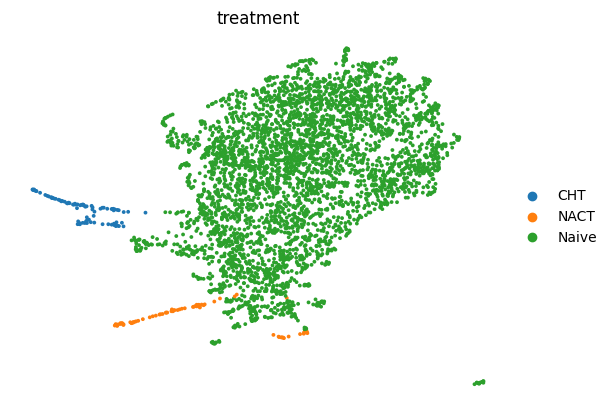

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


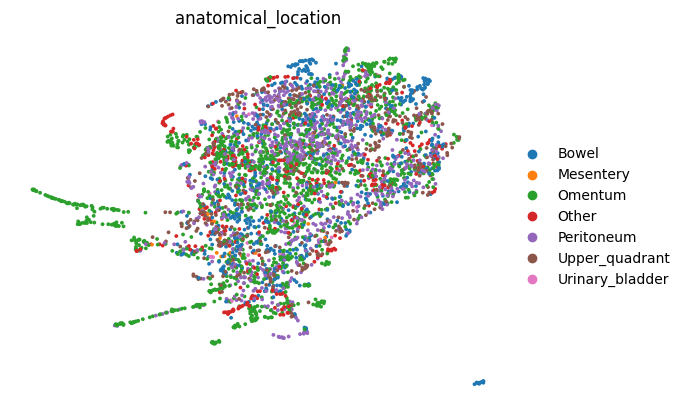

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


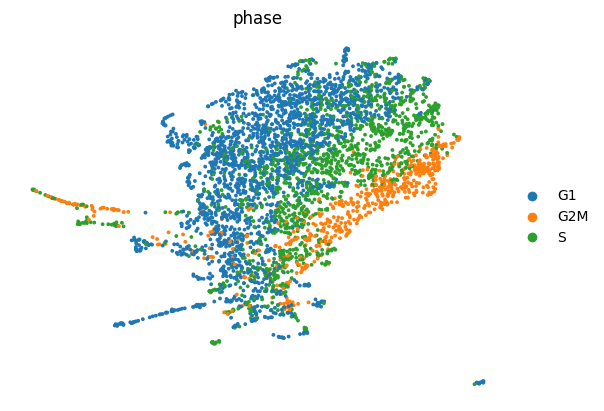

In [26]:
sc.pl.umap(adata_mt, color=["treatment"], frameon=False)
sc.pl.umap(adata_mt, color=["anatomical_location"], frameon=False)
sc.pl.umap(adata_mt, color=["phase"], frameon=False)

In [27]:
leidenTotal=[]
for i in np.arange(0.01, 2.0, 0.1):
    sc.tl.leiden(adata_mt,resolution = i,key_added="leiden-{}".format(round(i,2)))
    leidenTotal.append("leiden-{}".format(round(i,2)))

In [28]:
leidenTotal

['leiden-0.01',
 'leiden-0.11',
 'leiden-0.21',
 'leiden-0.31',
 'leiden-0.41',
 'leiden-0.51',
 'leiden-0.61',
 'leiden-0.71',
 'leiden-0.81',
 'leiden-0.91',
 'leiden-1.01',
 'leiden-1.11',
 'leiden-1.21',
 'leiden-1.31',
 'leiden-1.41',
 'leiden-1.51',
 'leiden-1.61',
 'leiden-1.71',
 'leiden-1.81',
 'leiden-1.91']

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


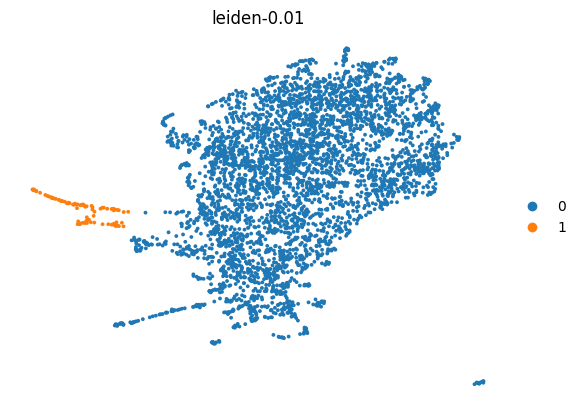

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


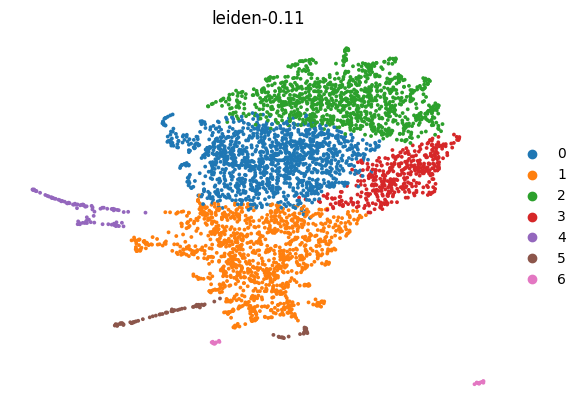

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


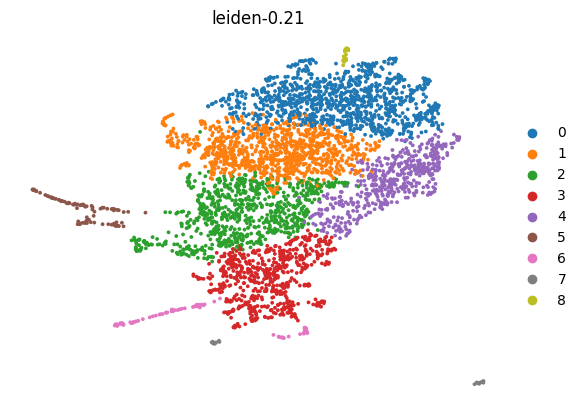

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


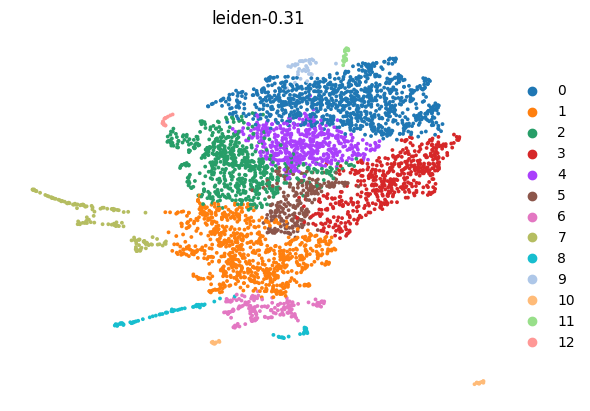

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


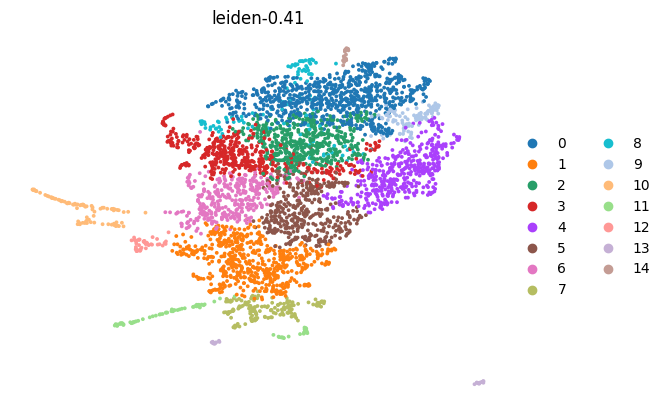

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


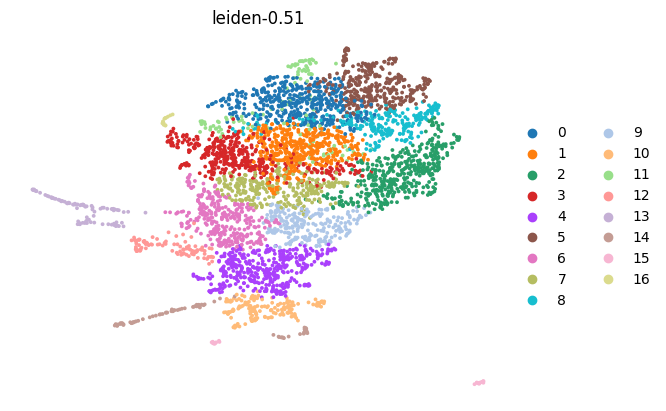

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


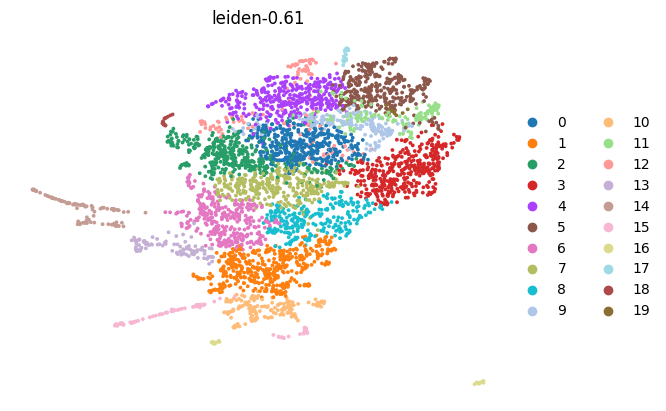

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


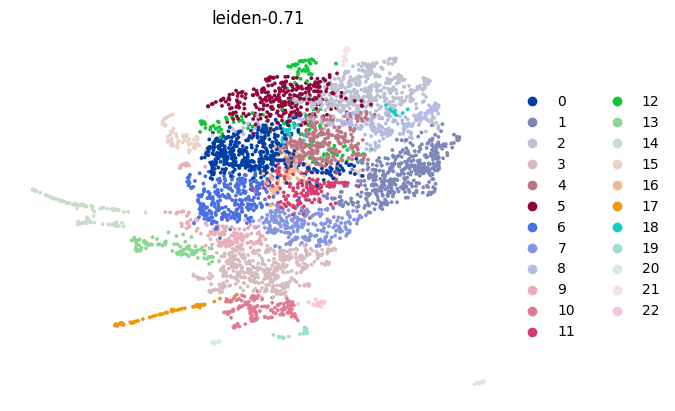

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


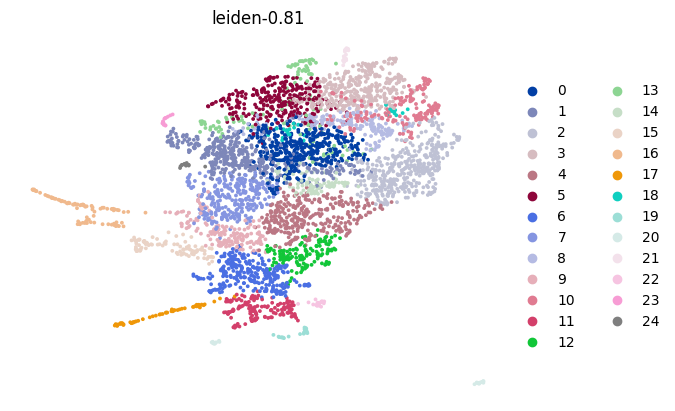

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


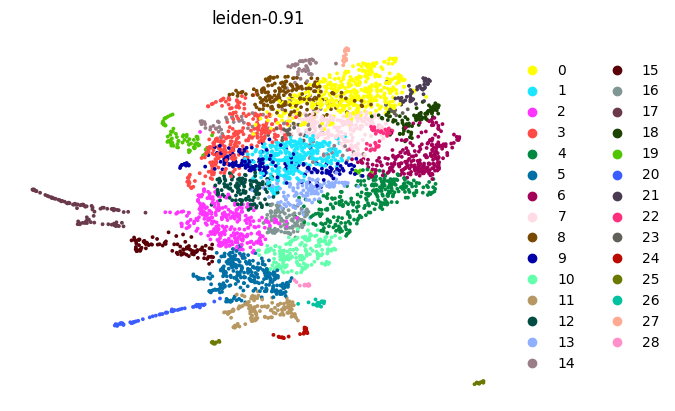

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


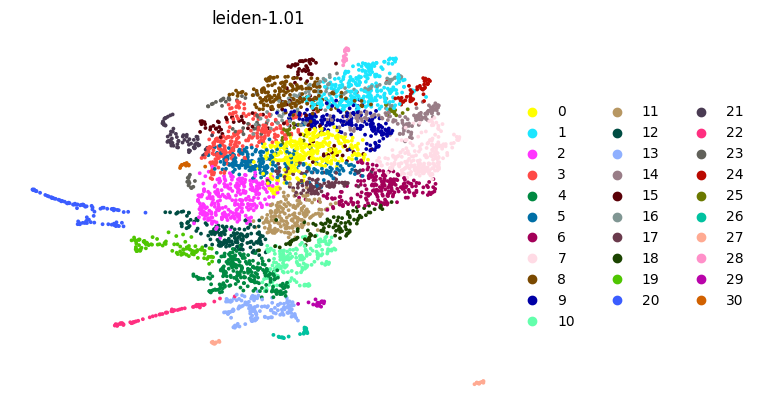

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


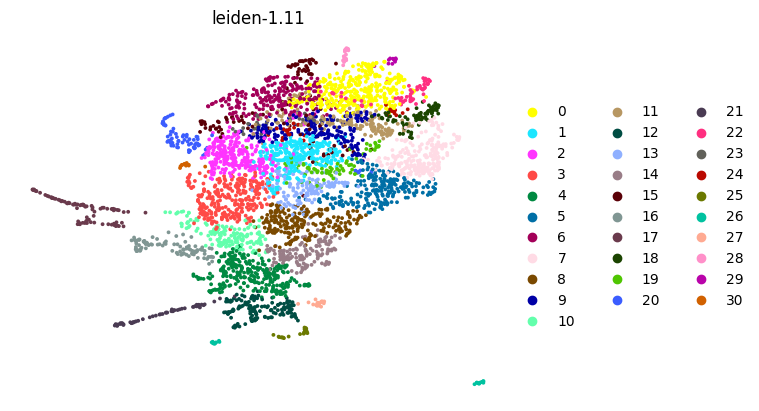

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


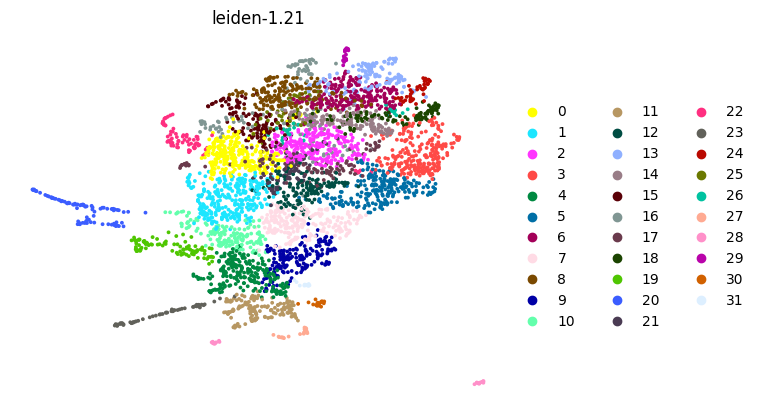

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


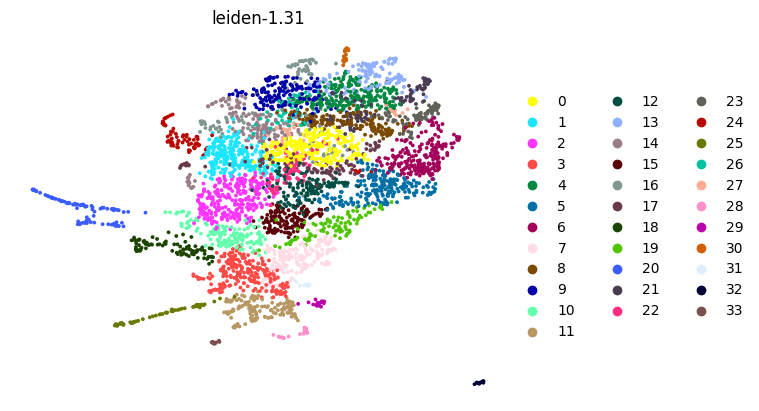

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


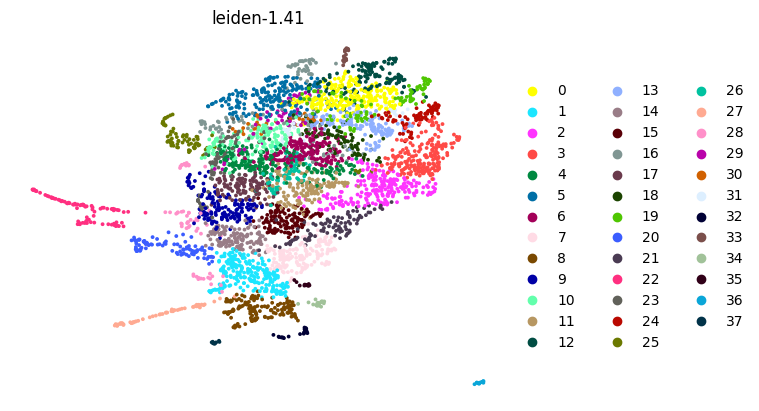

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


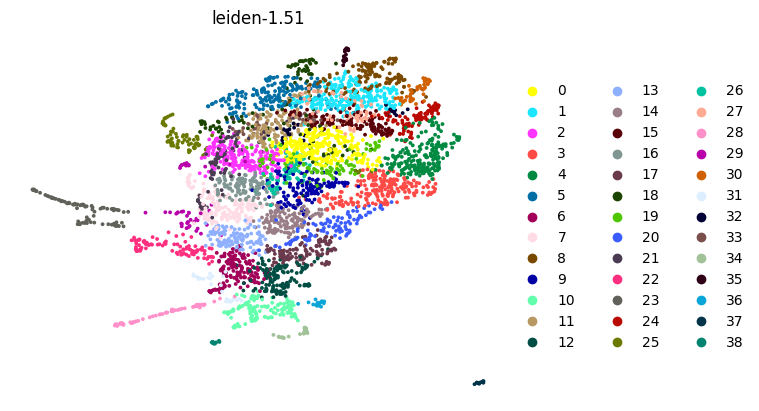

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


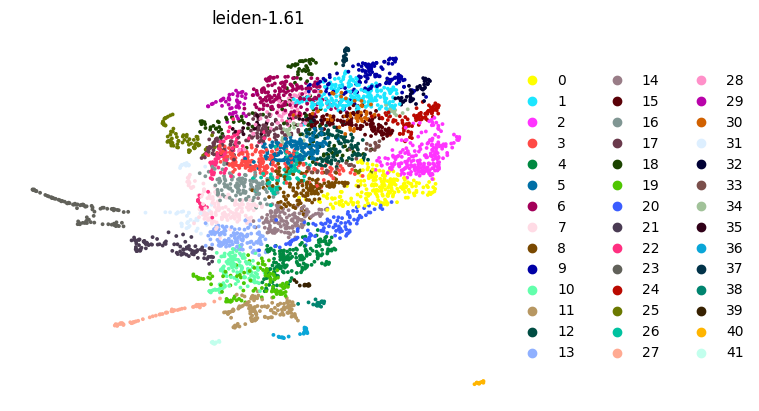

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


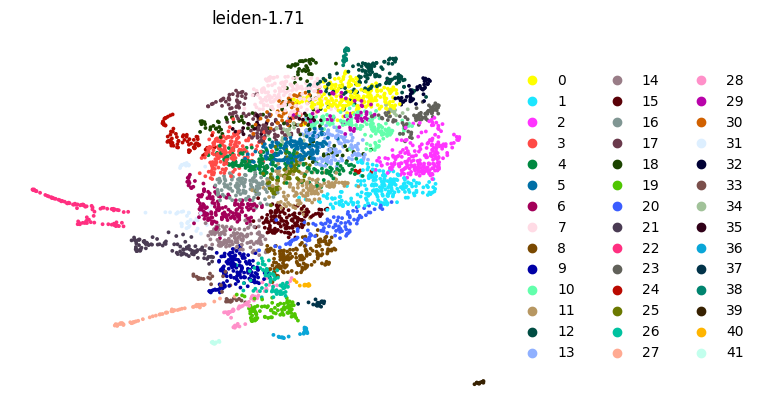

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


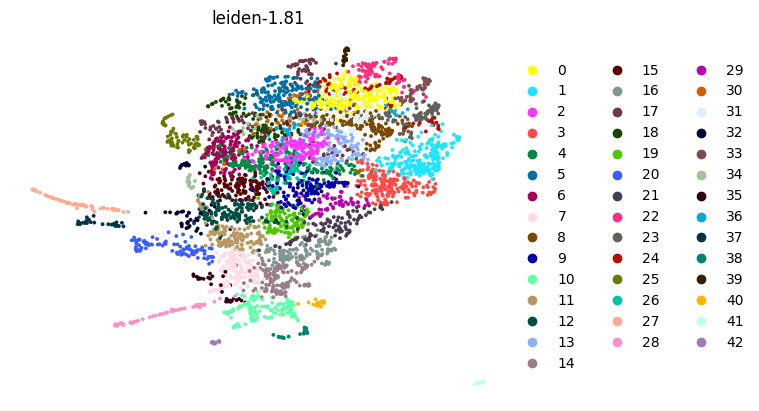

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


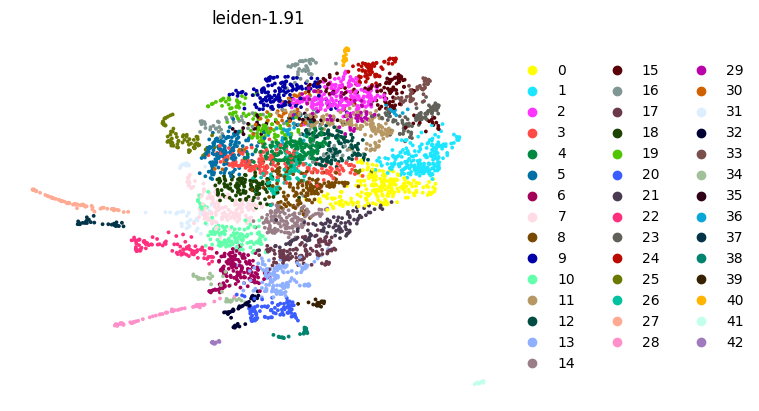

In [29]:
for i in leidenTotal:
   sc.pl.umap(adata_mt, color=i, frameon=False) 

In [30]:
dedf={}
for lei in leidenTotal:
    dedf[lei]={}
    sc.tl.rank_genes_groups(adata_mt, groupby=lei, method='wilcoxon', key_added = "wilcoxon_"+lei)
    for cl in adata_mt.obs[lei].unique():
        dedf[lei][cl] = sc.get.rank_genes_groups_df(adata_mt, group=cl, key ='wilcoxon_'+lei)

/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marta.sallese/miniconda3/envs/gprofiler/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning

In [31]:
directory_root = "/home/marta.sallese/ov_cancer_atlas/atlas_project/script/downstream/clustering/cancer/metastasis/"

errorDic={}
log_file = directory_root + 'metastasis.log'

# Check if the log exists
if os.path.isfile(log_file):
# If it doesn't exist, create it
    os.remove(log_file)

logging.basicConfig(filename=log_file, level=logging.INFO) 
                    # format='%(metastasis)s %(levelname)s %(name)s %(message)s')
logger=logging.getLogger(__name__)

for lei in leidenTotal:
    errorDic[lei]={}
    directory = directory_root + lei
    # Check if the directory exists
    if not os.path.exists(directory):
        # If it doesn't exist, create it
        os.makedirs(directory)
    else:
        shutil.rmtree(directory)
        os.makedirs(directory)
    for cl in adata_mt.obs[lei].unique():
        dedf[lei][cl] = sc.get.rank_genes_groups_df(adata_mt, group=cl, key ='wilcoxon_'+lei)
        dedf[lei][cl].to_csv(directory + '/rank_gene_groups_df_' + cl + '.csv')
        try:
            # print(dedf[lei][cl])
            threshold1 = dedf[lei][cl].dropna(axis='rows')
            threshold2 = threshold1.loc[(threshold1['logfoldchanges'] > 1) & (threshold1['logfoldchanges'] < 100), :]
            threshold3 = threshold2.loc[threshold2['scores'] > 5, :]
            threshold4 = threshold3.loc[threshold3['pvals_adj'] < 0.05, :]
            # break
            print('{}_{}_{}_{}'.format(lei, cl, threshold4.shape[0], threshold4.scores.min()))
            # ontologia di (dedf[lei][cl])
            gp = GProfiler(return_dataframe=True)
            query = threshold4.names.to_list()
            ontology = gp.profile(organism='hsapiens', 
                                    query=query, 
                                    no_evidences=False, 
                                    background=adata_mt.var_names.to_list(),
                                    sources=['GO:CC', 'GO:BP', 'GO:MF','REAC','KEGG'])
            ontology.to_csv(directory + '/gprofiler_' + cl + '.csv')
            if ontology.shape[0] > 0:
                plot_enrich(ontology, filename=directory + '/ontology_' + cl + '.png')
            else:
                logger.info('leiden {} cluster {}'.format(lei, cl))
                logger.info('ontology empty')
            
            
            errorDic[lei][cl]={}

        except Exception as e:
            errorDic[lei][cl]=e
            # with open(directory + '/ontology_' + cl + '.log', 'w') as f:
            #     f.write('error')
            logger.info('leiden {} cluster {}'.format(lei, cl))
            logger.error(e)
            continue

logging.shutdown()


leiden-0.01_1_7269_5.002665996551514
leiden-0.01_0_1529_5.046420574188232
leiden-0.11_4_7183_5.007425785064697
leiden-0.11_0_328_5.316192150115967
leiden-0.11_2_13790_5.224450588226318
leiden-0.11_1_69_6.266566276550293
leiden-0.11_3_923_5.105982303619385
leiden-0.11_5_507_5.012197971343994
leiden-0.11_6_65_5.015347957611084
leiden-0.21_5_7183_5.007425785064697
leiden-0.21_1_424_5.062452793121338
leiden-0.21_0_13670_5.144429683685303
leiden-0.21_2_90_5.29813289642334
leiden-0.21_3_61_5.729166507720947
leiden-0.21_4_718_5.126187324523926
leiden-0.21_6_507_5.012197971343994
leiden-0.21_7_65_5.015347957611084
leiden-0.21_8_13699_5.0005574226379395
leiden-0.31_7_5873_5.007884502410889
leiden-0.31_4_1096_5.322155952453613
leiden-0.31_0_13493_5.021003246307373
leiden-0.31_2_66_5.299495697021484
leiden-0.31_1_80_5.167355537414551
leiden-0.31_3_696_5.450872421264648
leiden-0.31_6_56_5.327732086181641
leiden-0.31_8_501_5.023075580596924
leiden-0.31_5_107_5.0417656898498535
leiden-0.31_9_11361_5

In [32]:
logging.shutdown()

In [33]:
adata_mt.write_h5ad('/group/testa/Project/OvarianAtlas/atlas_project/raw_data/downstream/clustering/cancer/adata_metastasis_embeddings.h5ad')